# Mínimos Quadrados: Interpolação Polinomial

Primeiramente, definimos as constantes que serão usadas ao longo do programa:
- \``points`\`: conunto de pontos $(x_i, y_i)$ usados na interpolação.
- \``deg`\`: o grau da função polinomial gerada para a interpolação.
- \``rcond`\`: define a proporção a partir da qual os valores singulares são desconsiderados.
- \``alpha`\`: o valor de $\alpha$ usado na regularização de Tikhonov.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

points = np.array([
    [1,14],
    [2, 0],
    [3, 3],
    [4,-9],
    [5, 0],
    [6, 6]])

deg = 5
rcond = 1e-6
alpha = 1

Em seguida, definimos por conveniência as funções auxiliares \``poly`\` e \``polymat`\`. A primeira é usada no cálculo do valor de $y = f(x)$, onde $f$ é o polinômio definido pelos coeficientes em \``p`\`. Ou seja:

$f(x) = p_0 x^n + p_1 x^{n-1} + \cdots + p_n$

Já a segunda função é usada na geração da matriz da interpolação polinomial. Isto é:

$ A = \begin{pmatrix}
    x_1^k   & x_1^{k-1} & \cdots & 1       \\
    x_2^k   & x_2^{k-1} & \cdots & 1       \\
    \vdots  & \vdots    & \ddots & \vdots  \\
    x_m^k   & x_m^{k-1} & \cdots & 1
  \end{pmatrix} $

Onde $m$ é o número de pontos e $k$ o grau do polinômio desejado.

In [2]:
def poly(p, x):
    y = 0
    for i, pi in enumerate(reversed(p)):
        y += pi * x**i
    return y

def polymat(x, deg):
    M, = x.shape
    a = np.empty((M, deg+1))
    for i in range(deg+1):
        a[:,i] = x**(deg-i)
    return a

## Pseudo-inversa

O primeiro método que iremos explorar para a resolução do sistema é através da pseudo-inversa da matriz $A$ de interpolação polinomial. Como visto em aula, a resolução através da pseudo-inversa equivale a resolver o problema de otimização descrito por:

$ Ax = b \\
  \min \begin{Vmatrix}x\end{Vmatrix}_2 $

A função \``lstsqr`\`, definida em seguida, encontra a solução do sistema $Ax = b$ através da pseudo-inversa da matriz $A$. Como visto em aula, esta solução é dada por:

$ x = A^{-1}b = V\Sigma^+U^Tb $

Onde $A = U\Sigma V^T$ é a decomposição SVD de $A$. O valor \``rcond`\` é usado na eliminação de valores singulares durante a construção de $\Sigma^+$. Seja $\sigma_{max}$ o maior valor singular de $A$, $\sigma_i$ é dado como zero caso $\begin{Vmatrix}\sigma_i/\sigma_{max}\end{Vmatrix} <$ \``rcond`\` para todo $\sigma_i$.

In [3]:
def lstsq(a, b, rcond=0):
    u, s, vt = np.linalg.svd(a)
    s_plus = np.zeros_like(a).T
    for i, si in enumerate(s):
        s_plus[i,i] = 1/si if abs(si) >= abs(rcond * s[0]) else 0
    return vt.T @ s_plus @ u.T @ b

E abaixo a solução encontrada a partir deste método para os pontos definidos anteriormente:

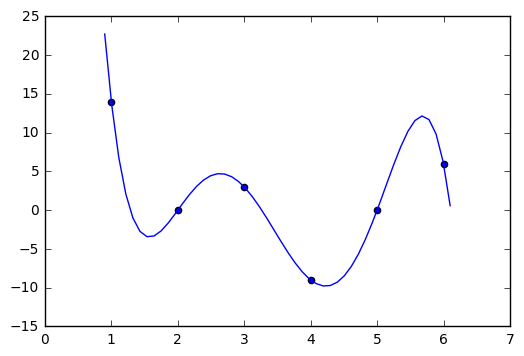

In [4]:
# Exibe o polinômio resultante em 0.9 < x < 6.1

a = polymat(points[:,0], deg)
p = lstsq(a, points[:,1], rcond=rcond)
x = np.linspace(0.9, 6.1, 50)
y = [poly(p, xi) for xi in x]

plt.scatter(points[:,0], points[:,1])
plt.plot(x, y)
plt.show()

### Parâmetro \``rcond`\`

Porém, também pode-se observar que embora o polinômio aproxime bem os pontos em questão ele também apresenta um comportamento imprevisível em partes do domínio. Em especial, o valor do polinômio tanto à esquerda quanto à direita dos pontos toma valores de módulo estremamente alto.

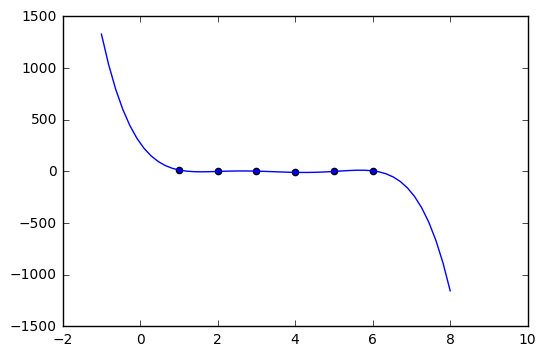

In [5]:
# Exibe o polinômio resultante em -1 < x < 8

x = np.linspace(-1, 8, 50)
y = [poly(p, xi) for xi in x]

plt.scatter(points[:,0], points[:,1])
plt.plot(x, y)
plt.show()

Isto acontece pois ao tentar interpolar os pontos de forma exata o polinômio toma coeficientes muito grandes em \``p`\`. Uma maneira de lidar com o problema é ajustando o valor de \``rcond`\`. Em seguida, diversos valores são demonstrados na interpolação dos pontos. Fica então evidente como este valor tem efeito dramático no polinômio resultante:

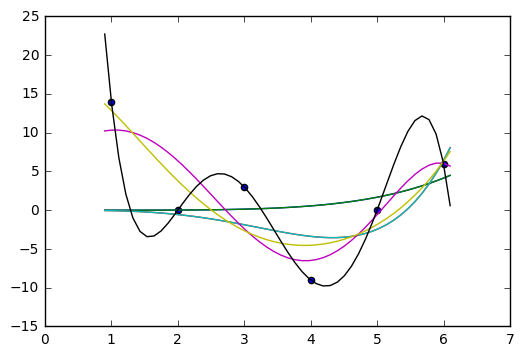

In [6]:
# Exibe o resultado da interpolação com diversos valores de `rcond`

for i in range(7):
    rcond = 0.1**i
    p = lstsq(a, points[:,1], rcond=rcond)
    x = np.linspace(0.9, 6.1, 50)
    y = [poly(p, xi) for xi in x]
    plt.plot(x, y)

plt.scatter(points[:,0], points[:,1])
# plt.legend() # Removido para melhorar a visibilidade
plt.show()

### Número de graus

Outra escolha a ser feita na interpolação se trata do grau do polinômio. Até o momento, o grau escolhido do polinômio tem sido o necessário para interpolar os pontos de forma exata. Mas este parâmetro pode ser escolhido de forma arbitrária, dado que o método de mínimos quadrados irá encontrar os coeficientes que melhor aproximam os pontos para qualquer grau. Abaixo são demonstrados os efeitos desta escolha.

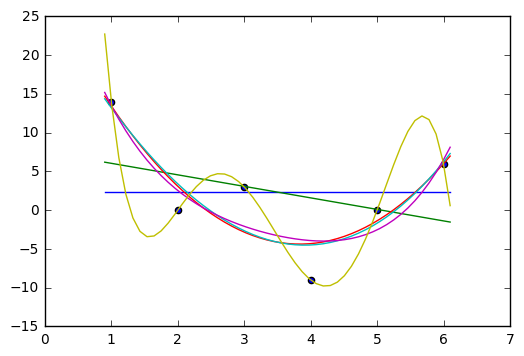

In [7]:
# Exibe o resultado da interpolação através de polinômios de grau 0 a 5 inclusive

for i in range(6):
    a = polymat(points[:,0], i)
    p = lstsq(a, points[:,1], rcond=rcond)
    x = np.linspace(0.9, 6.1, 50)
    y = [poly(p, xi) for xi in x]
    plt.plot(x, y, label='deg=%d' % i)

plt.scatter(points[:,0], points[:,1])
# plt.legend() # Remova o comentário para exibir a legenda
plt.show()

Também é possível escolher valores ainda maiores para o grau do que o necessário para interpolar os pontos. Porém, como pode ser visto abaixo, o polinômio encontrado tende a apresentar oscilações cada vez maiores:

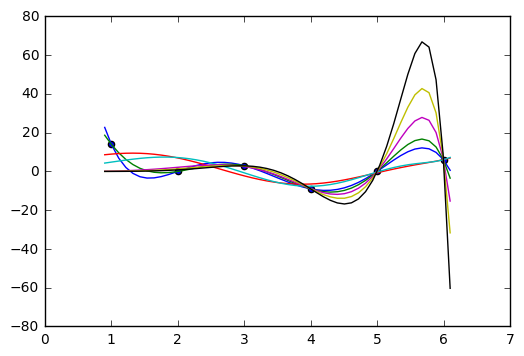

In [8]:
# Exibe o resultado da interpolação através de polinômios de grau 5 a 11 inclusive

for i in range(5, 12):
    a = polymat(points[:,0], i)
    p = lstsq(a, points[:,1], rcond=rcond)
    x = np.linspace(0.9, 6.1, 50)
    y = [poly(p, xi) for xi in x]
    plt.plot(x, y, label='deg=%d' % i)

plt.scatter(points[:,0], points[:,1])
# plt.legend() # Remova o comentário para exibir a legenda
plt.show()

## Regularização de Tikhonov

A regularização de Tikhonov é outro método que também pode ser utilizado na resolução do sistema. Ele equivale a resolver o problema de otimização descrito por:

$ \min \begin{Vmatrix}Ax - b\end{Vmatrix}^2 + \alpha\begin{Vmatrix}x\end{Vmatrix}^2 $

Neste caso, o parâmetro $\alpha$ pode ser ajustado para minizar tanto o erro quanto a norma do vetor solução. Com $\alpha = 0$, o problema equivale a resolução por mínimos quadrados e encontra o $x$ que melhor aproxima a solução do sistema. Porém, conforme o valor de $\alpha$ cresce, a redução da norma de $x$ passa a se tornar prioridade. Portanto, encontrar uma boa solução depende de fazer uma boa escolha do parâmetro $\alpha$.

Abaixo é definida a função \``tikhonov`\` que encontra a solução através da regularização do sistema:

In [9]:
def tikhonov(a, b, alpha):
    return np.linalg.solve(a.T @ a + alpha, a.T @ b)

Como visto em aula, a resolução do sistema:

$ (A^TA + \alpha)x = A^Tb $

Equivale a encontrar a solução do problema de otimização inicial. Abaixo segue a solução encontrada para os pontos definidos inicialmente:

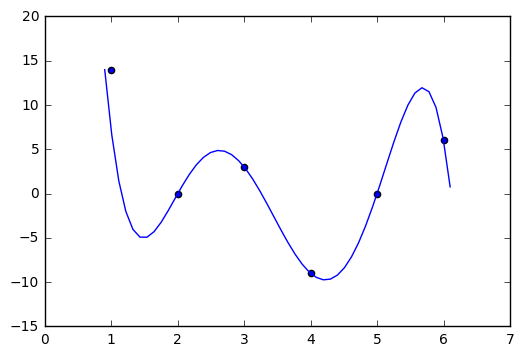

In [10]:
# Exibe o polinômio obtido através da regularização de Tikhonov

a = polymat(points[:,0], deg)
p = tikhonov(a, points[:,1], alpha=1)
x = np.linspace(0.9, 6.1, 50)
y = [poly(p, xi) for xi in x]

plt.scatter(points[:,0], points[:,1])
plt.plot(x, y)
plt.show()

### Parâmetro $\alpha$

Observa-se como o polinômio resultante sofre dos mesmos problemas que o polinômio obtido através da pseudo-inversa. Assim como no método da pseudo-inversa, também é possível ajustar esse polinômio a fim alterar seu aspecto. Nesse caso, altera-se o valor do parâmetro $\alpha$ que controla a minimização da norma de $x$. Em seguida são demonstrados diversos valores para este parâmetro e seu impacto na interpolação:

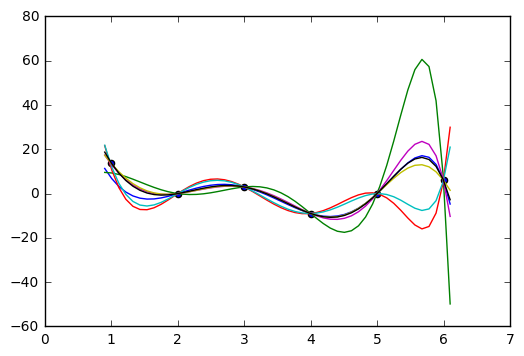

In [11]:
# Exibe o resultado da interpolação com diversos valores de `alpha`

a = polymat(points[:,0], 11)

for i in range(7):
    alpha = 0.5**i
    p = tikhonov(a, points[:,1], alpha=alpha)
    x = np.linspace(0.9, 6.1, 50)
    y = [poly(p, xi) for xi in x]
    plt.plot(x, y, label='alpha=2^-%d' % i)

plt.scatter(points[:,0], points[:,1])
# plt.legend() # Remova o comentário para exibir a legenda
plt.show()

Como pode ser visto, embora todos os polinômios passem próximos aos pontos, o comportamento de cada um difere nos intervalos entre eles. Além disso, como na pseudo-inversa, o grau do polinômio também pode ser ajustado de acordo com o resultado desejado para a interpolação. De fato, este tipo de ajuste se torna essencial ao se lidar com números maiores de pontos, já que o comportamento do polinômio se torna cada vez menos previsível conforme o grau cresce. Abaixo, pode ser observado o comportamento de um polinômio de grau muito alto:

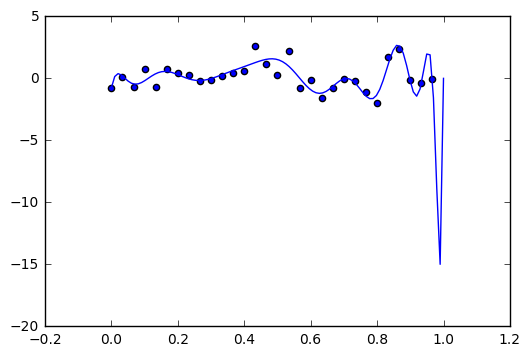

In [12]:
# Exibe a interpolação de `k` pontos através de polinômio de grau `k-1`

k = 30

rpoints = np.empty((k, 2))
for i in range(k):
    rpoints[i] = [i/k, np.random.randn()]

a = polymat(rpoints[:,0], k-1)
p = tikhonov(a, rpoints[:,1], alpha=alpha)
x = np.linspace(0, 1, 100)
y = [poly(p, xi) for xi in x]

plt.scatter(rpoints[:,0], rpoints[:,1])
plt.plot(x, y)
plt.show()

Em seguida, os mesmos pontos são aproximados através de um polinômio de grau menor:

In [13]:
# Exibe a interpolação de `k` pontos através de polinômio de grau 4

a = polymat(rpoints[:,0], 4)
p = tikhonov(a, points2[:,1], alpha=alpha)
x = np.linspace(0, 1, 100)
y = [poly(p, xi) for xi in x]

plt.scatter(rpoints[:,0], rpoints[:,1])
plt.plot(x, y)
plt.show()

NameError: name 'points2' is not defined